In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap, Normalize


In [18]:
data[data['country_name']=='Algeria']

region country_name country_code  min_date  max_date
1            Latin World      Algeria           dz    -100.0     500.0
36   mediterranean World      Algeria           dz    -100.0     500.0
71          Muslim world      Algeria           dz    -800.0    1900.0
219        Ottoman world      Algeria           dz    1600.0    1900.0
240         Arabic world      Algeria           dz    -800.0    1900.0

In [140]:
countries_iso_2 = pd.read_csv('../environnement_data/countries_codes_and_coordinates.csv')
countries_iso_2['Alpha-2 code'] = countries_iso_2['Alpha-2 code'].apply(lambda x: x.replace('"', '').lower())
countries_iso_2['Alpha-2 code'] = countries_iso_2['Alpha-2 code'].apply(lambda x: x.replace(' ', ''))

countries_iso_2['Alpha-3 code'] = countries_iso_2['Alpha-3 code'].apply(lambda x: x.replace('"', ''))
countries_iso_2['Alpha-3 code'] = countries_iso_2['Alpha-3 code'].apply(lambda x : x.replace(" ", ""))


countries_iso_2 = countries_iso_2.rename(columns = {'Alpha-3 code':'iso_a3', 'Alpha-2 code':'iso_a2'})

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = pd.merge(world, countries_iso_2, on = 'iso_a3')

# Read your data
data = pd.read_csv('../environnement_data/ENS - Cultural Index - Countries Databases - consolidate_table.csv')
data = data[['region', 'country_name', 'country_code', 'min_date', 'max_date']].copy()
data = data.rename(columns = {'country_code':'iso_a2'})
#data = data[data['region']=='Ottoman world']

gdf = gpd.GeoDataFrame(data)

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_9073/3180660751.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


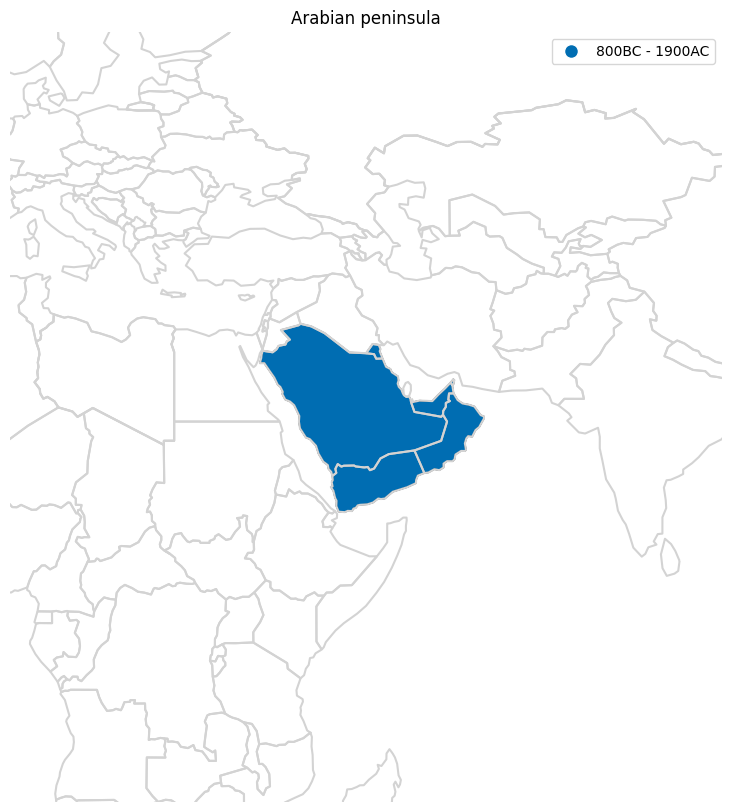

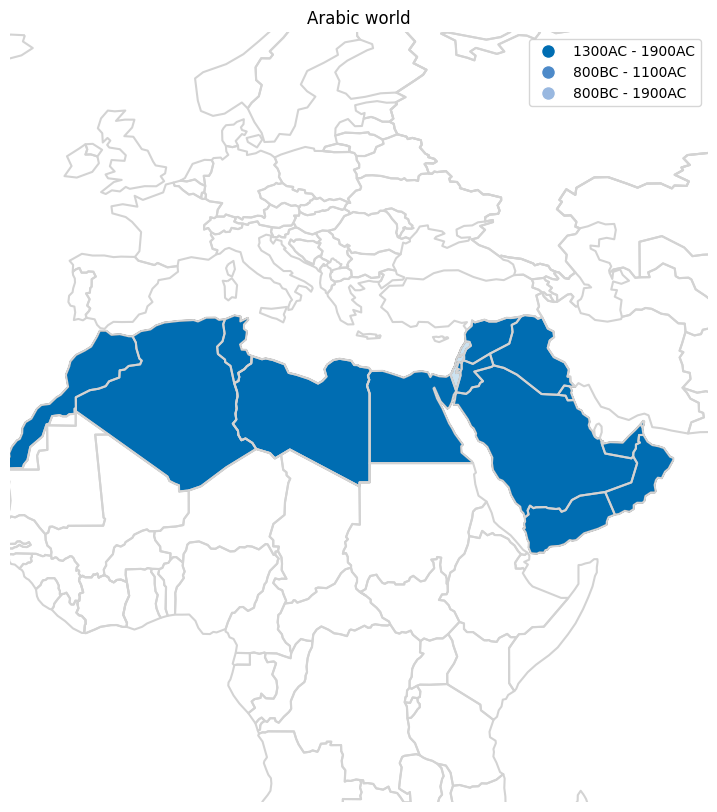

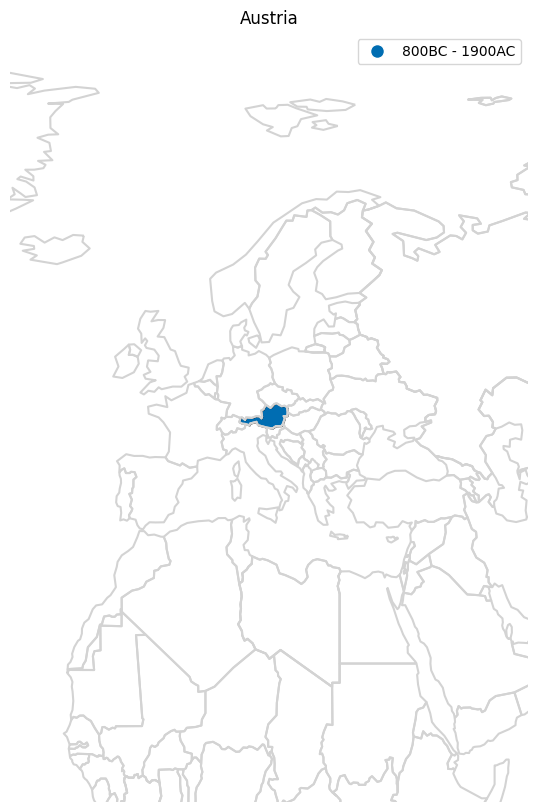

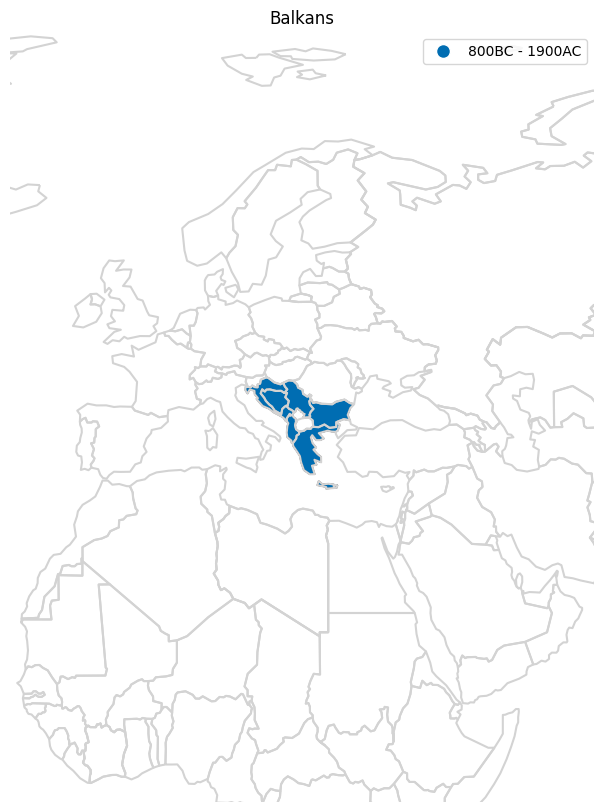

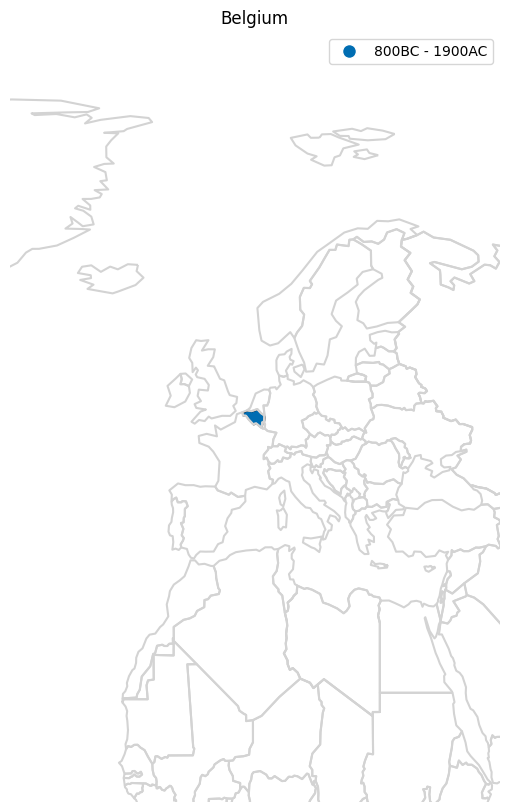

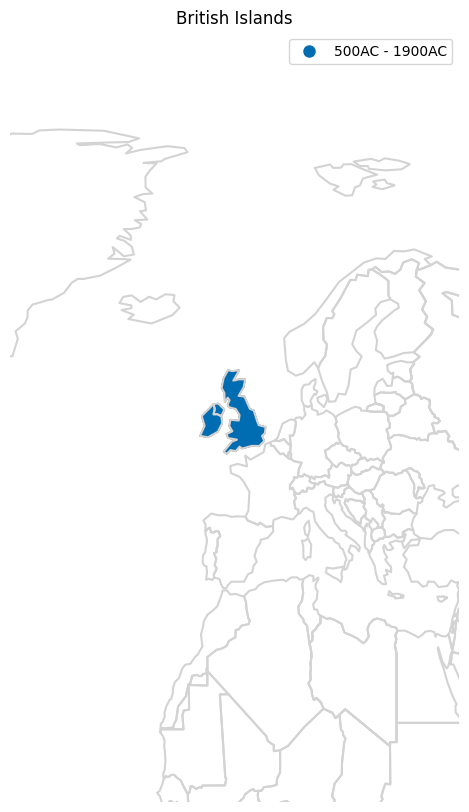

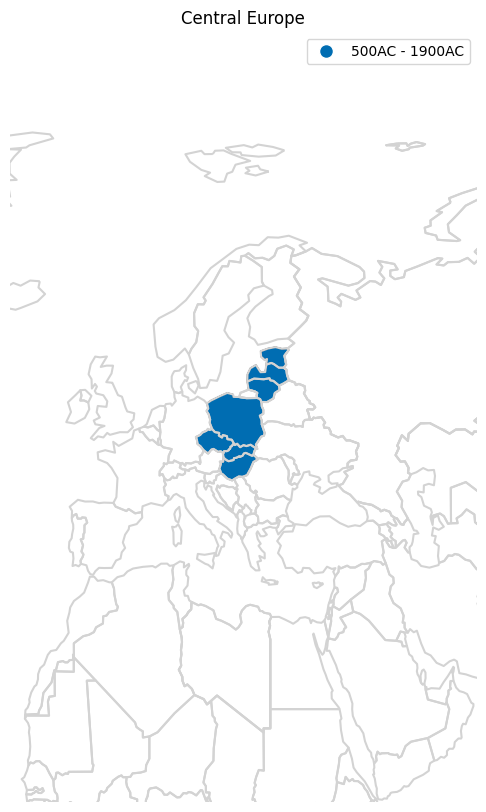

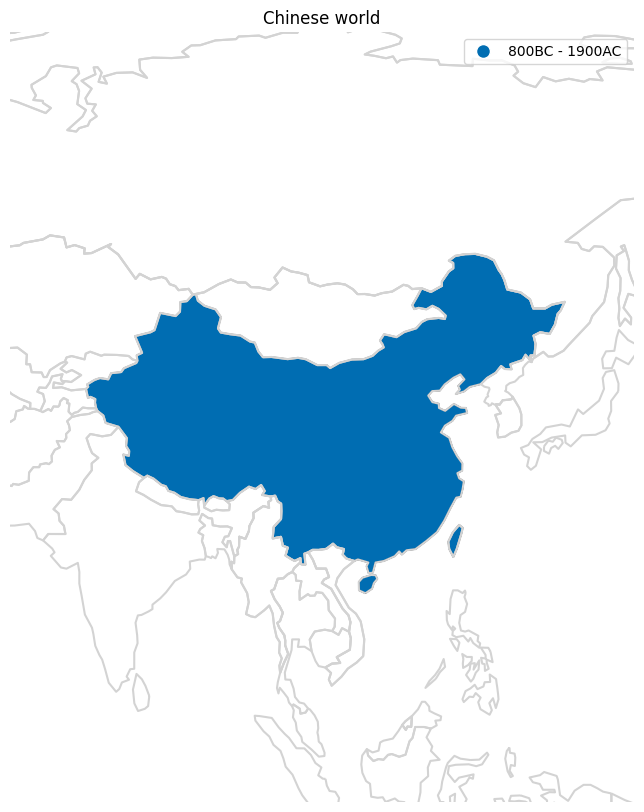

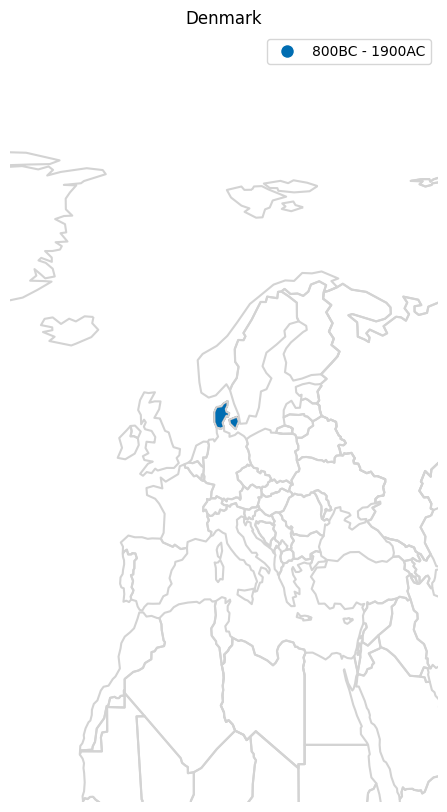

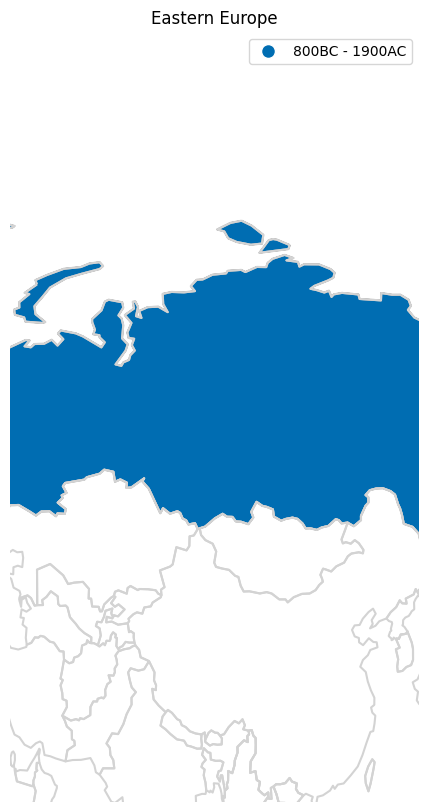

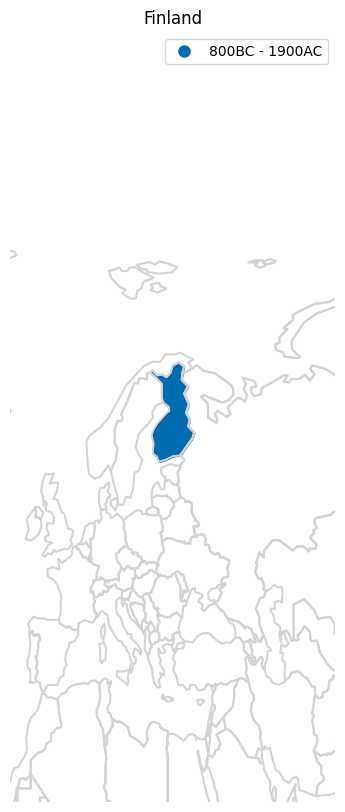

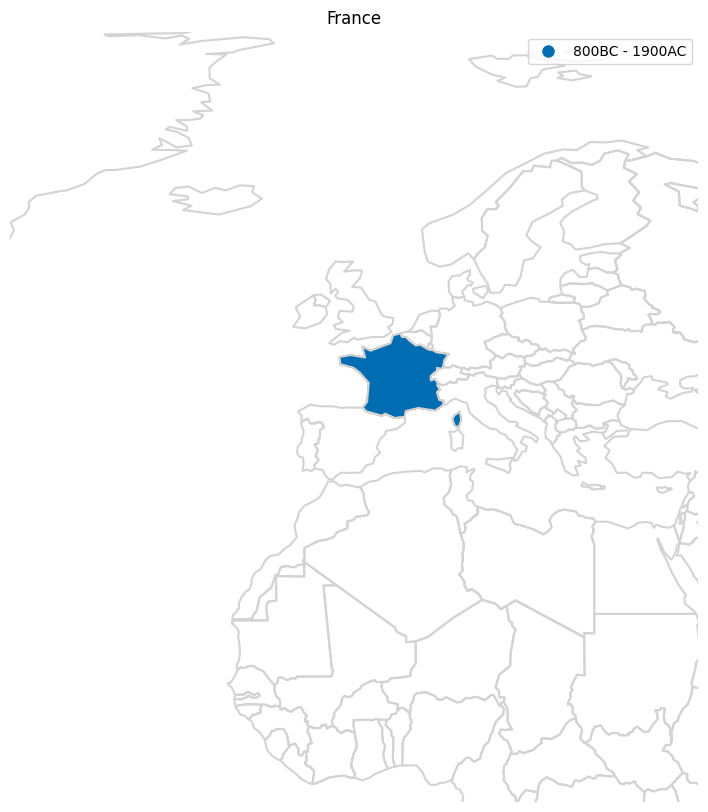

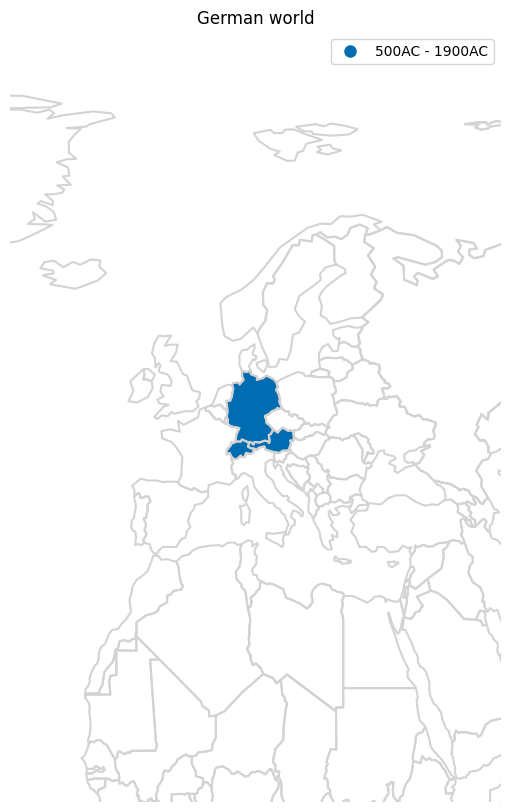

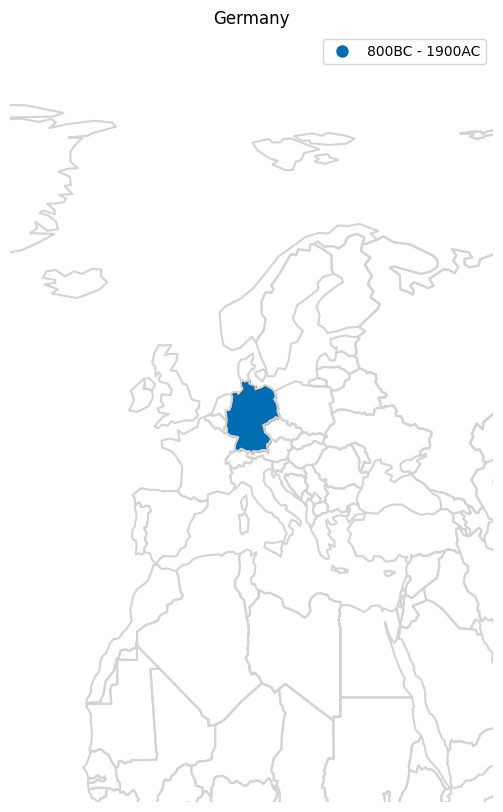

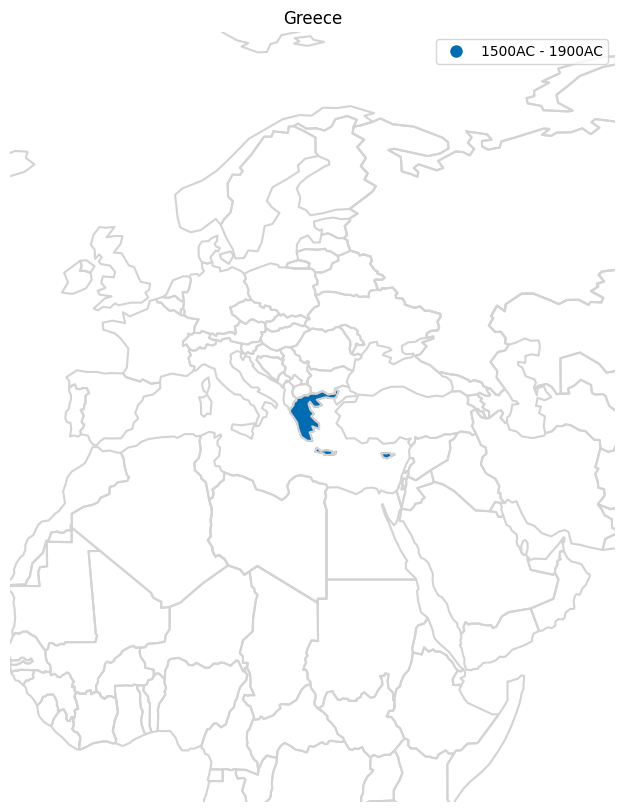

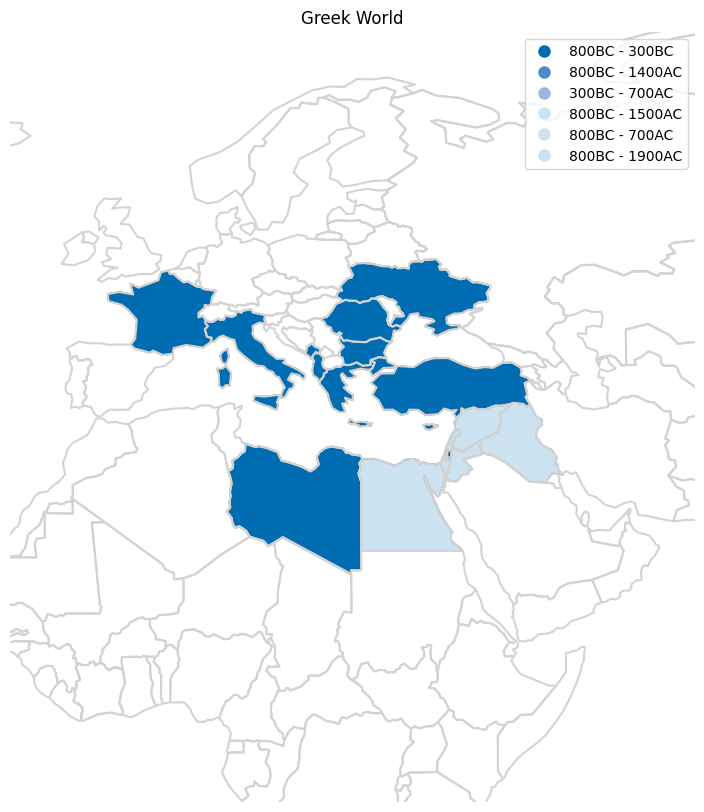

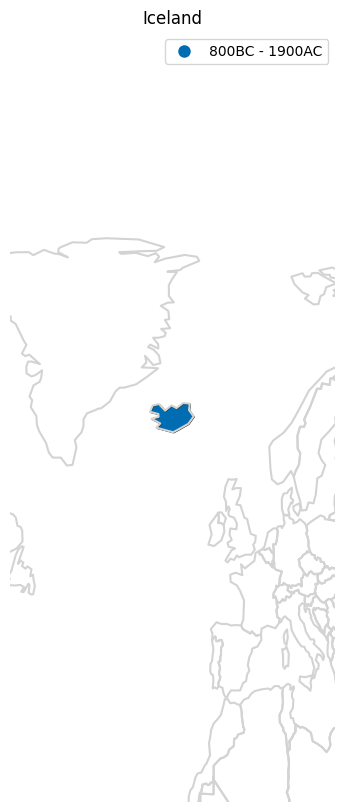

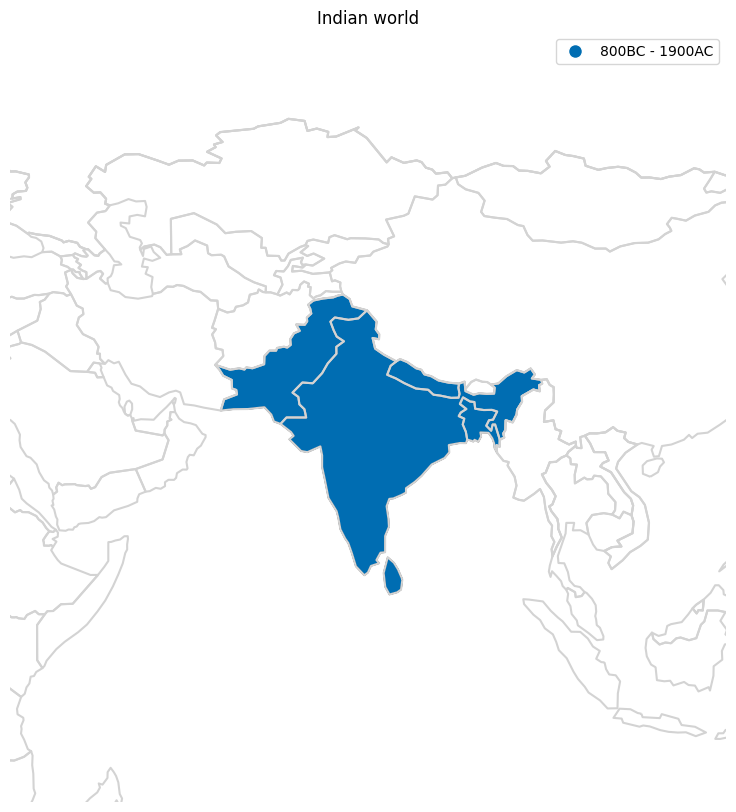

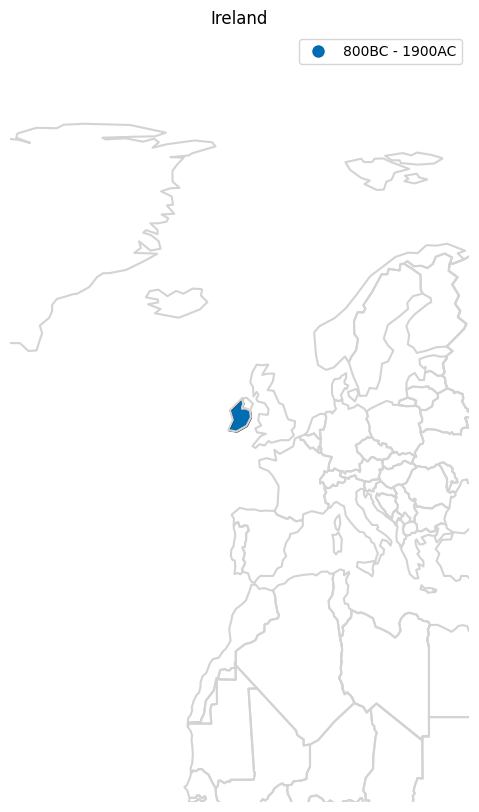

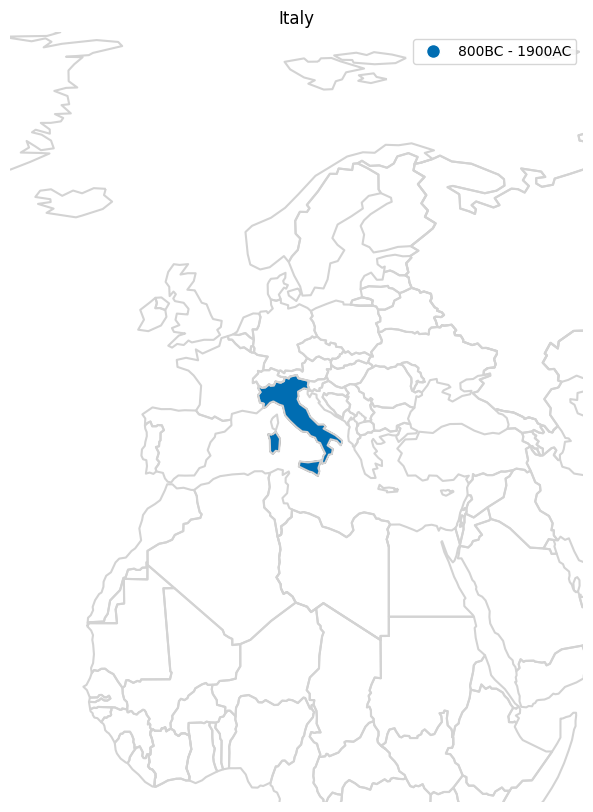

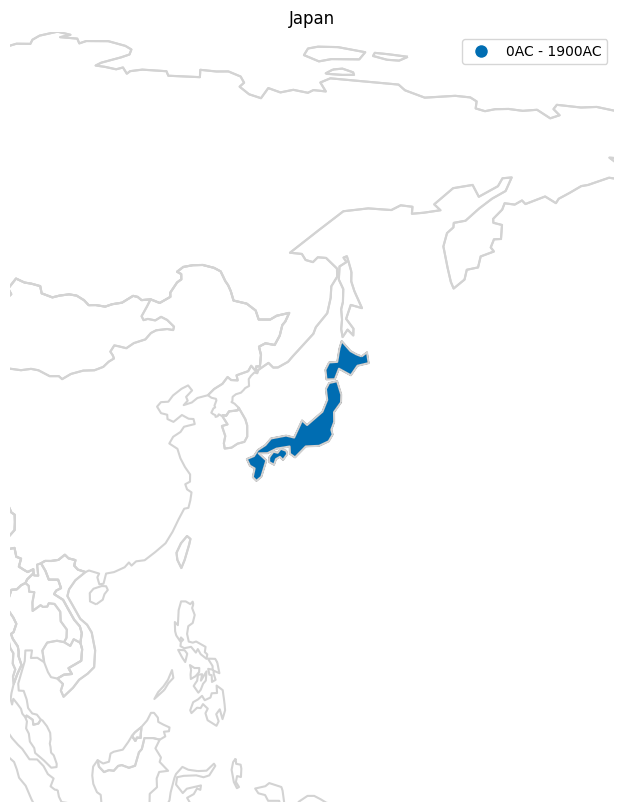

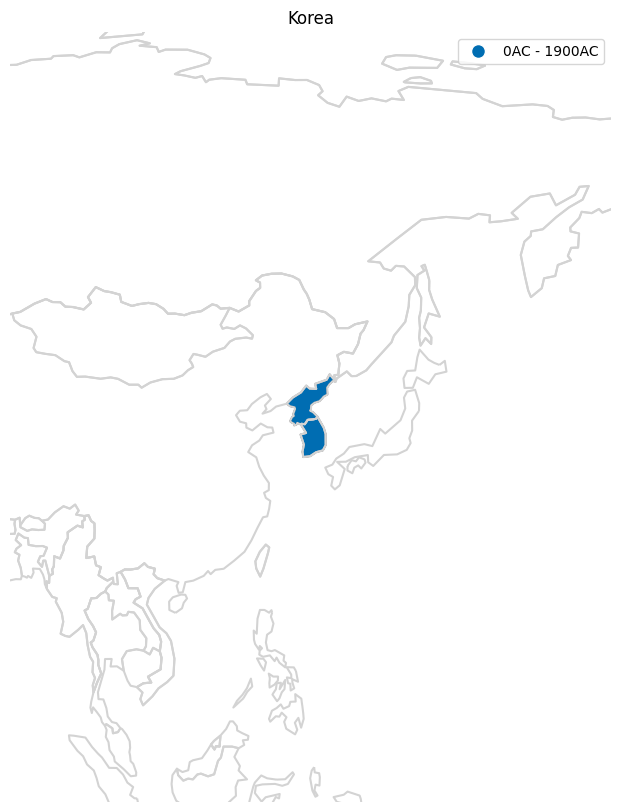

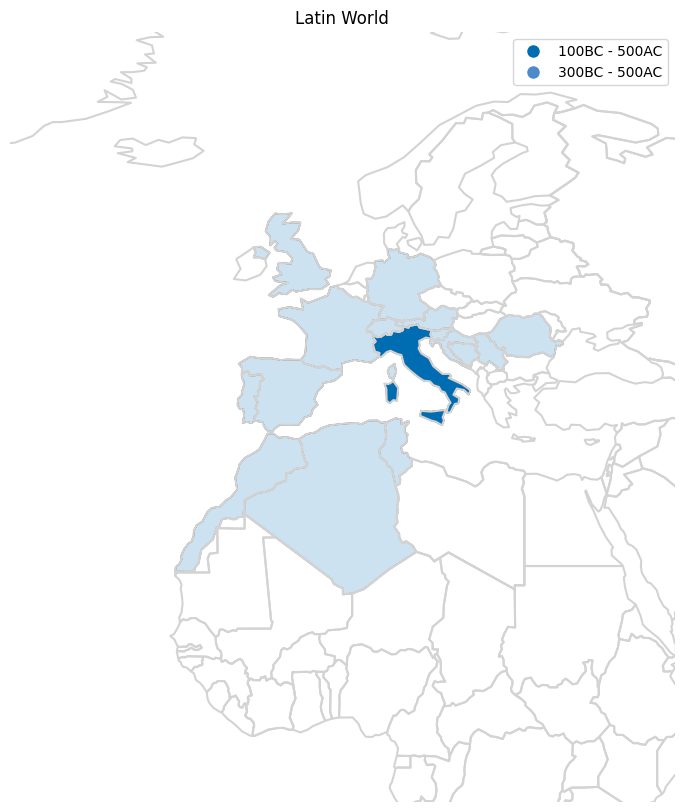

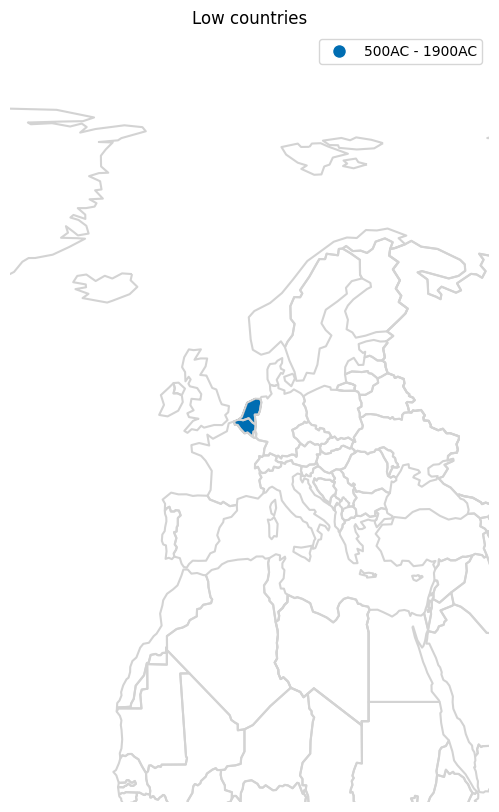

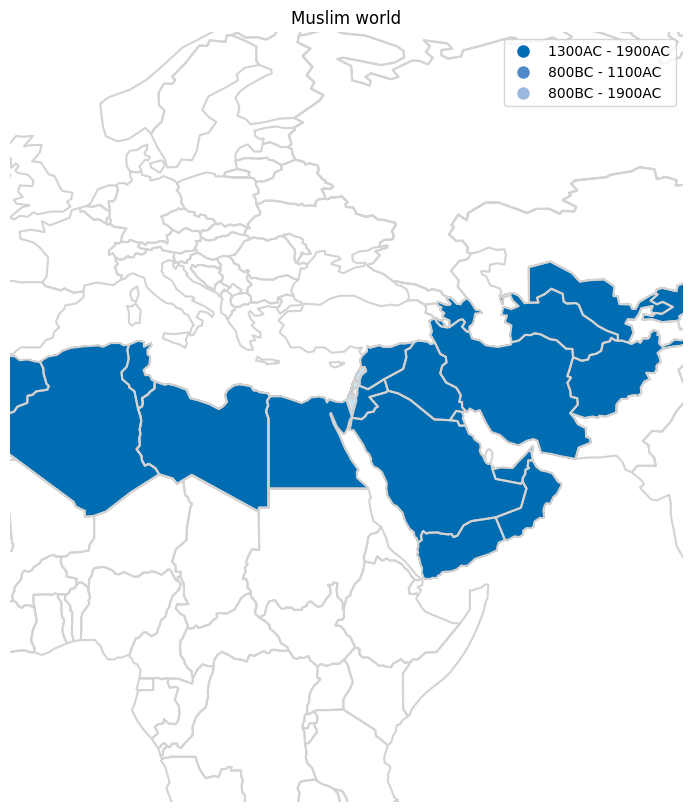

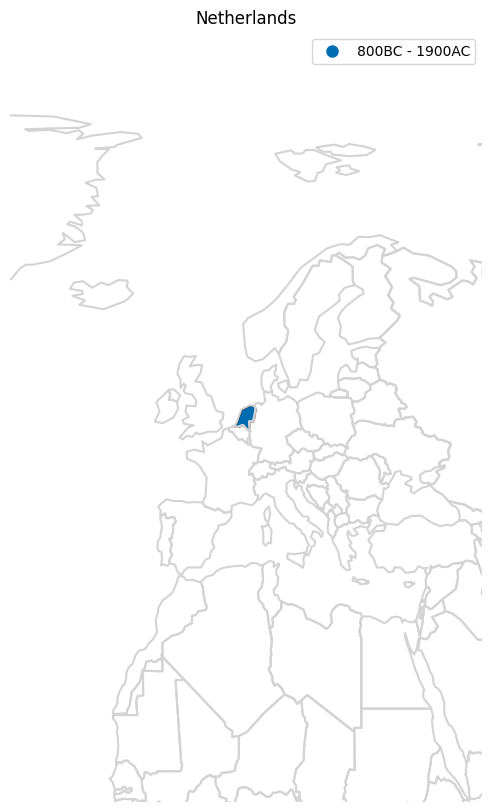

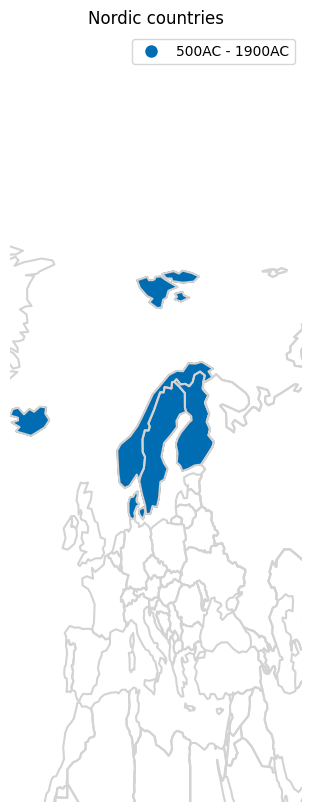

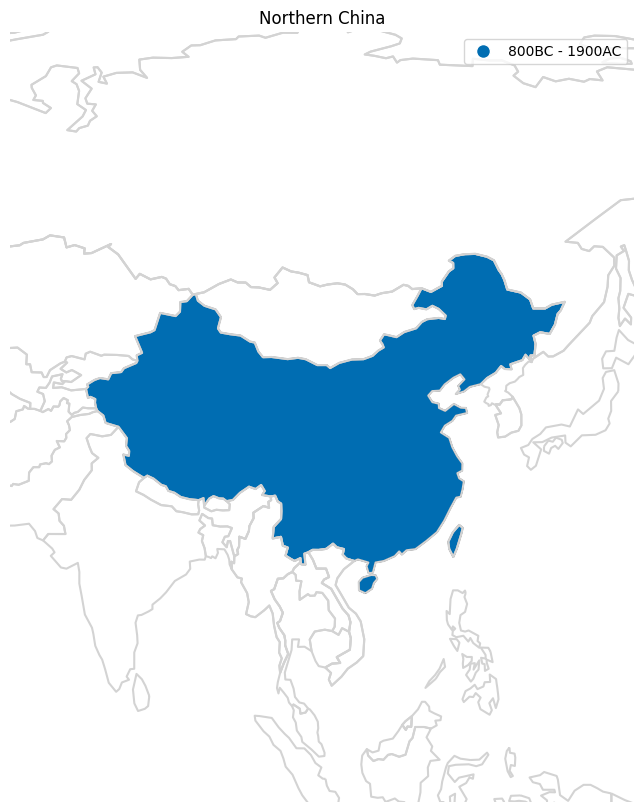

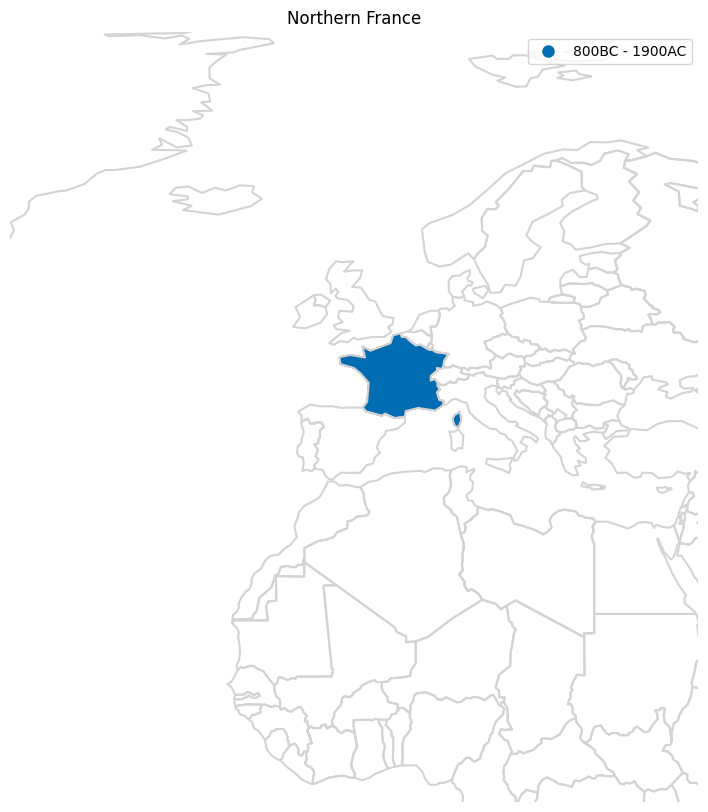

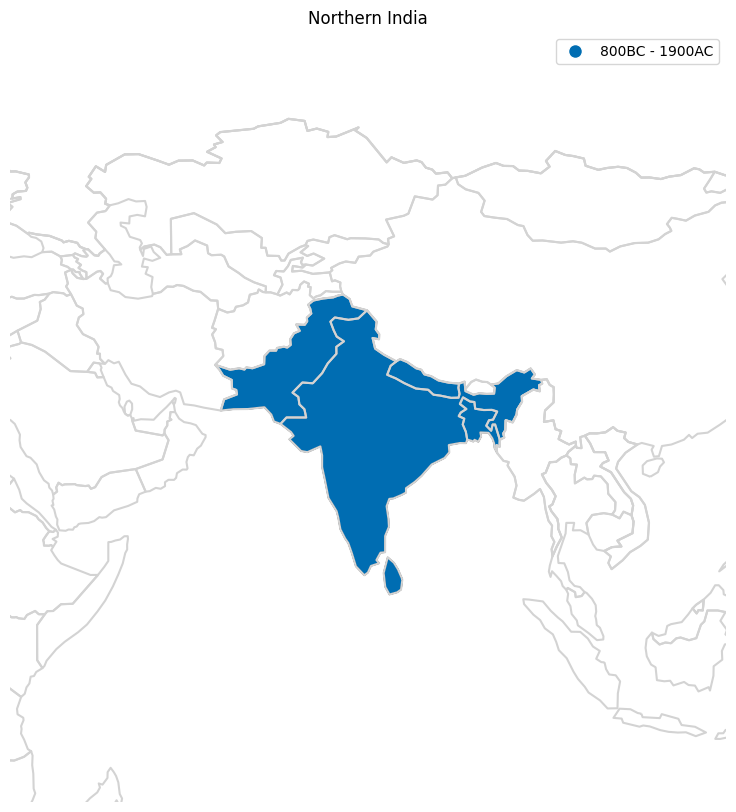

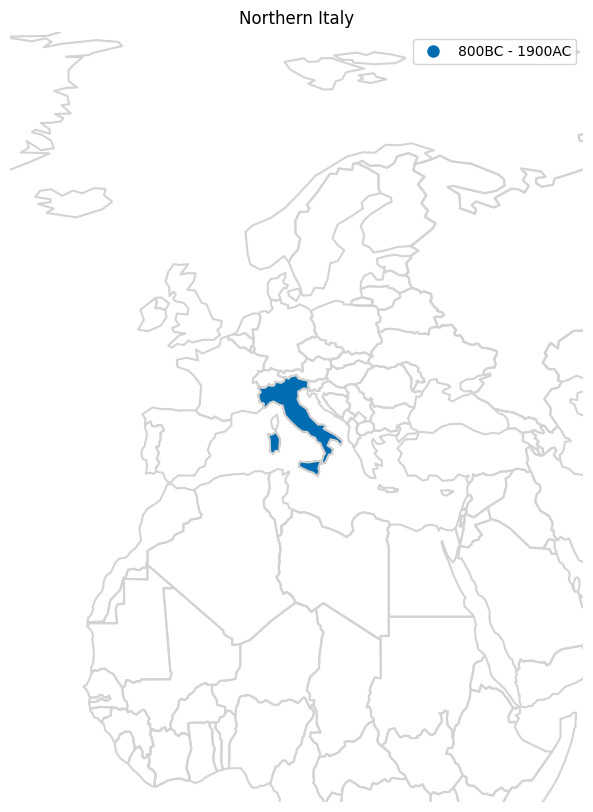

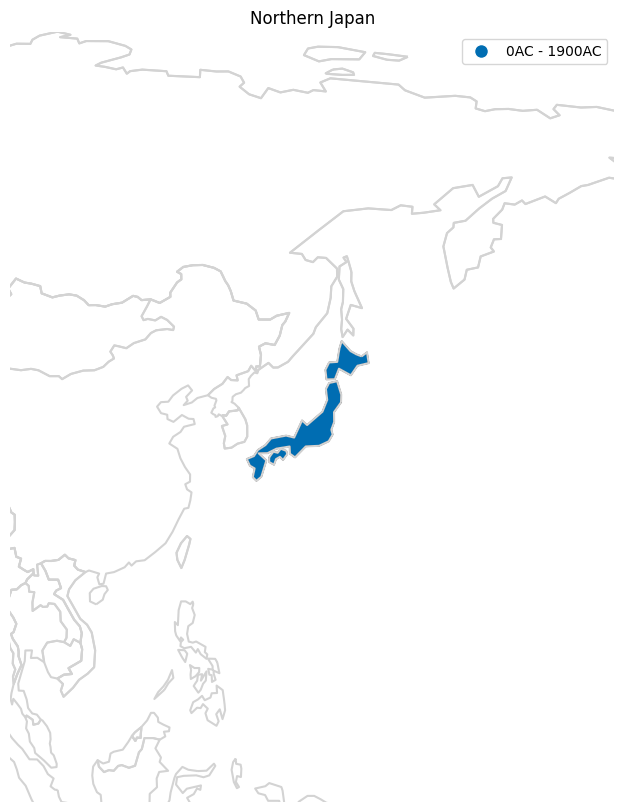

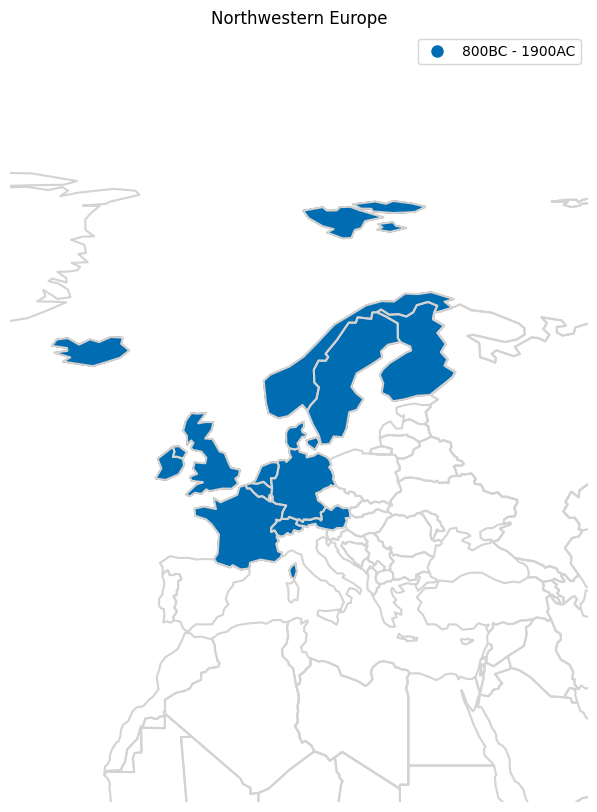

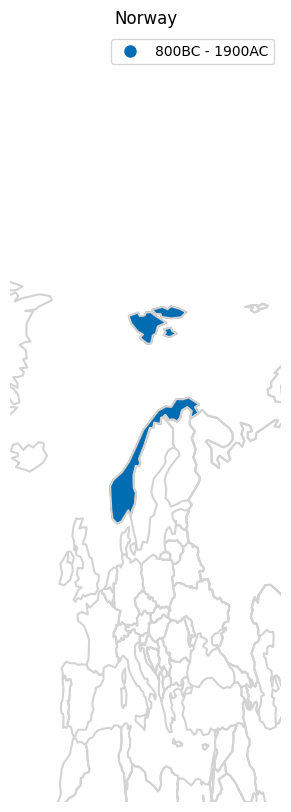

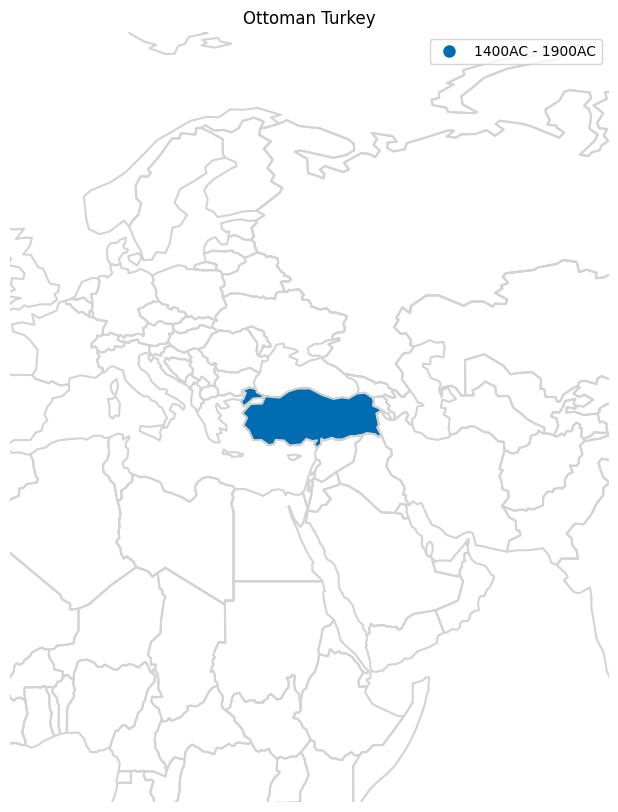

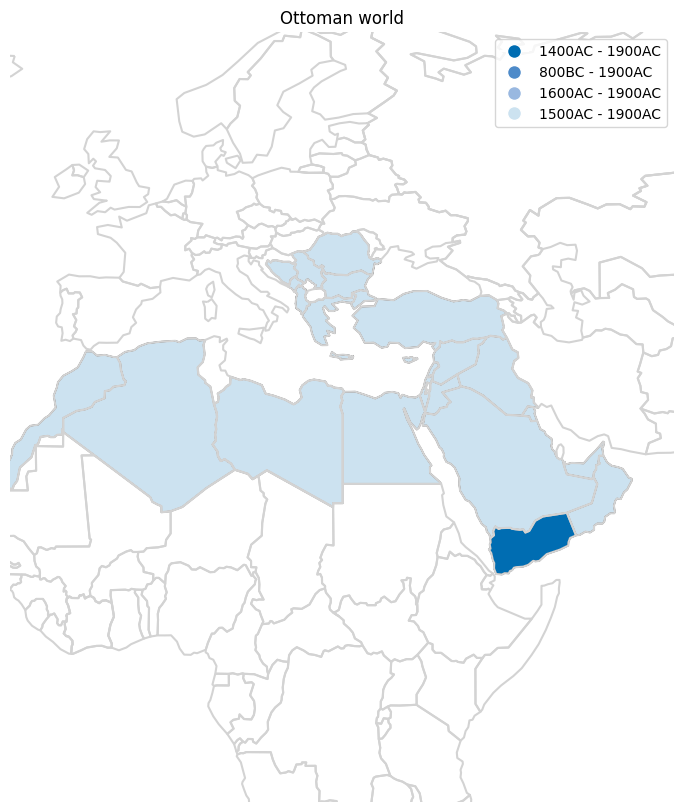

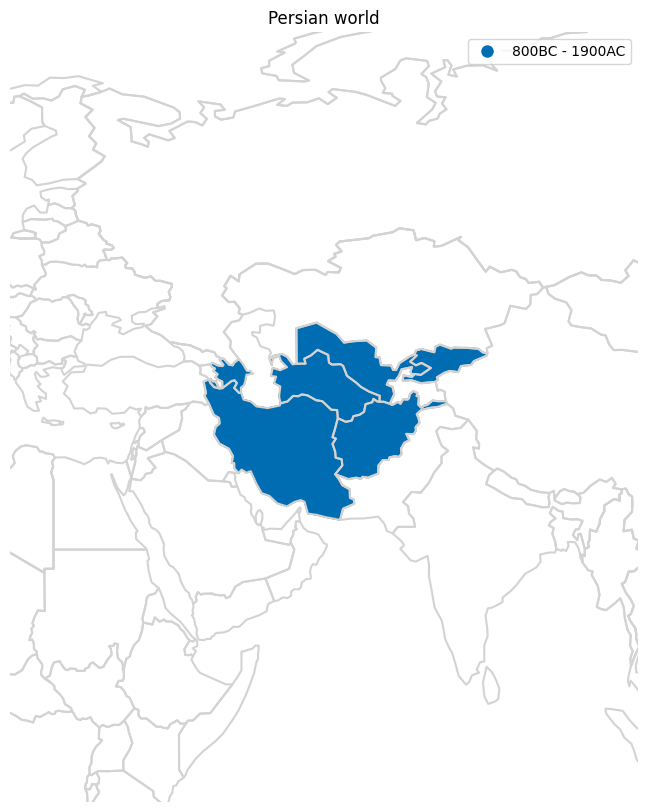

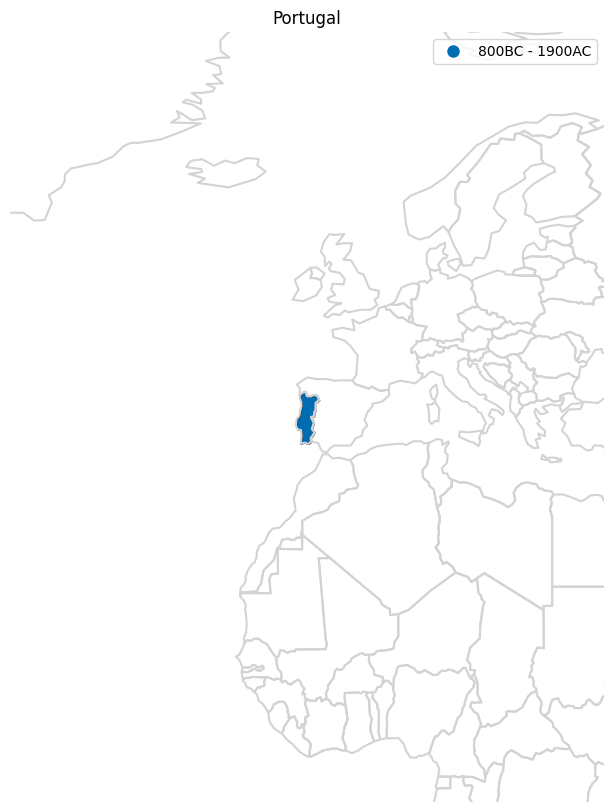

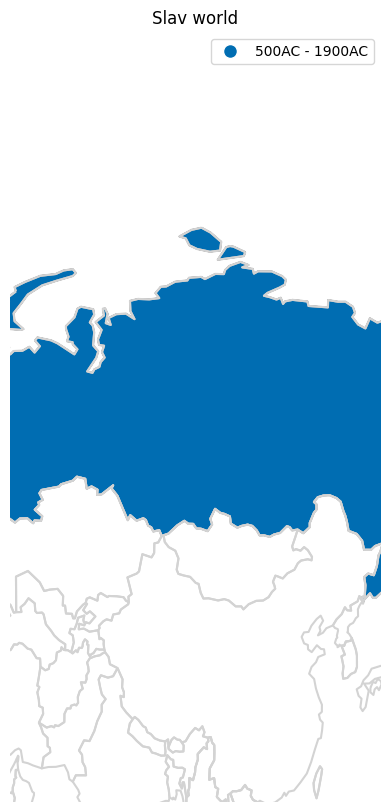

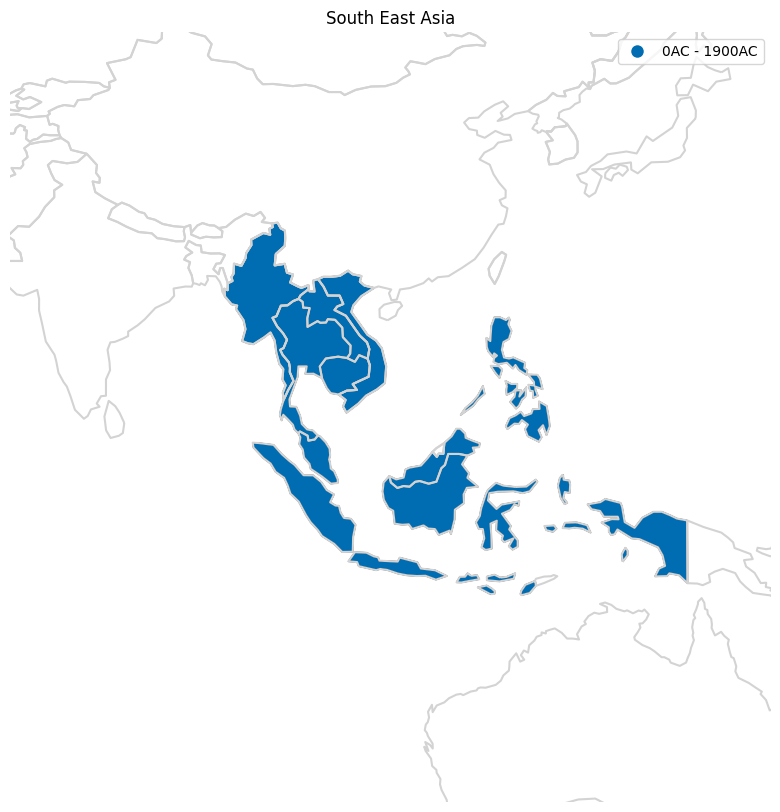

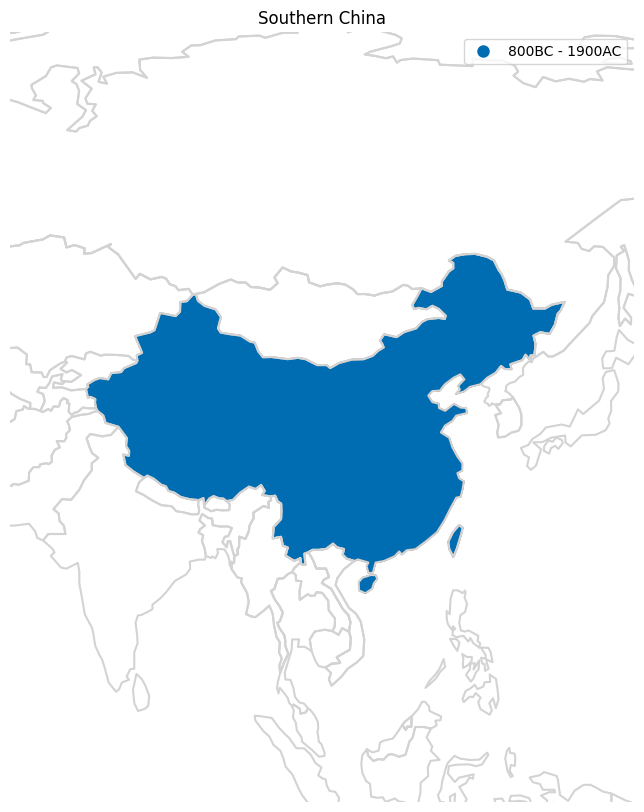

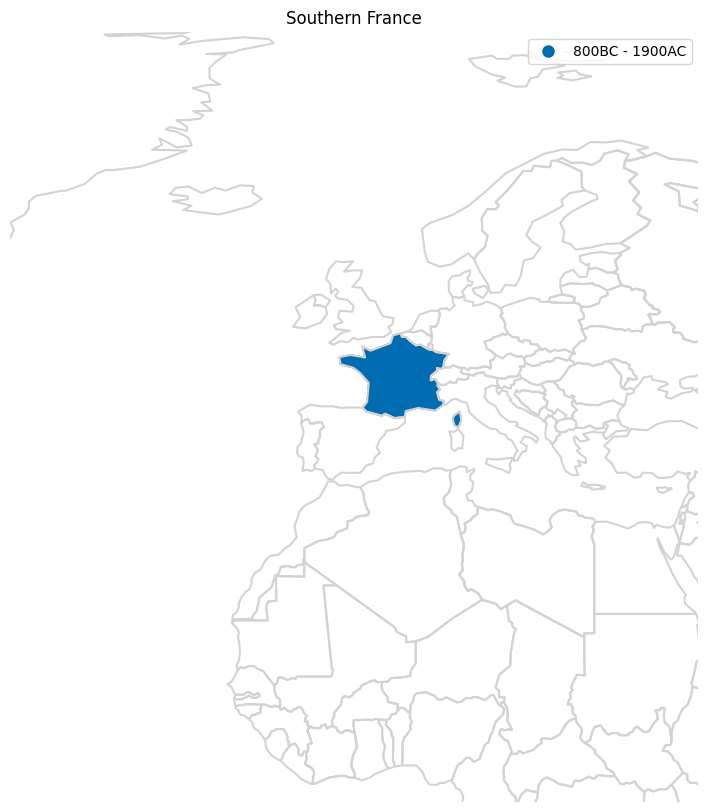

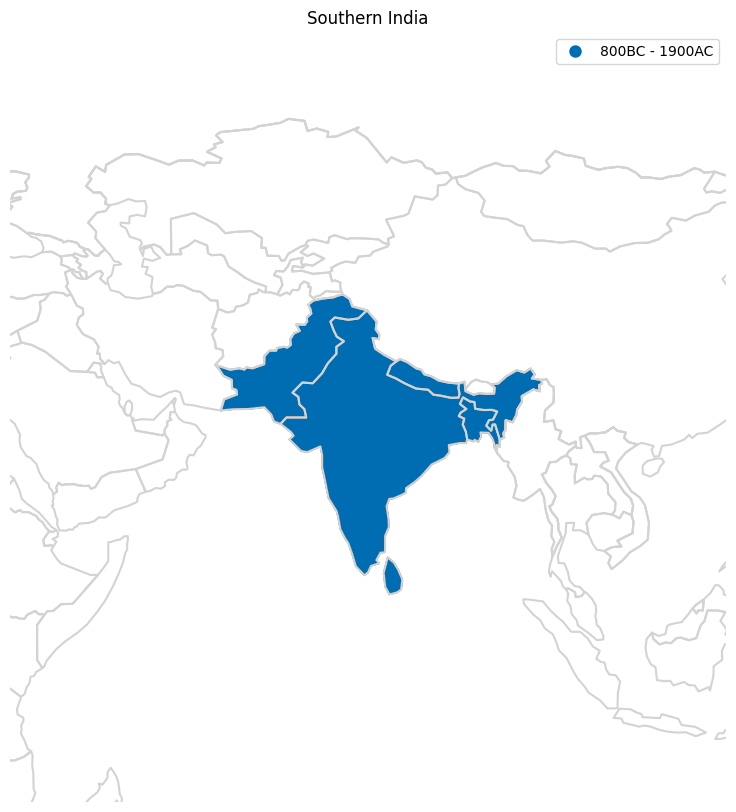

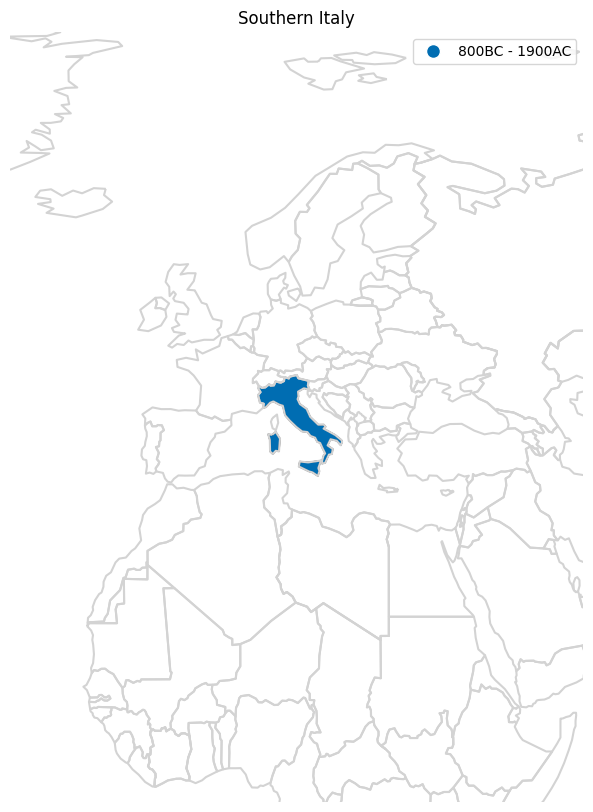

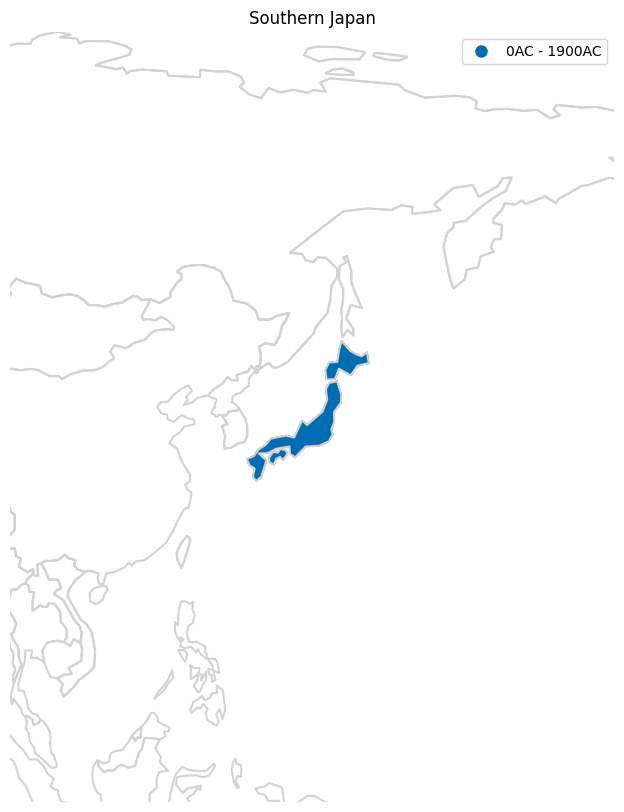

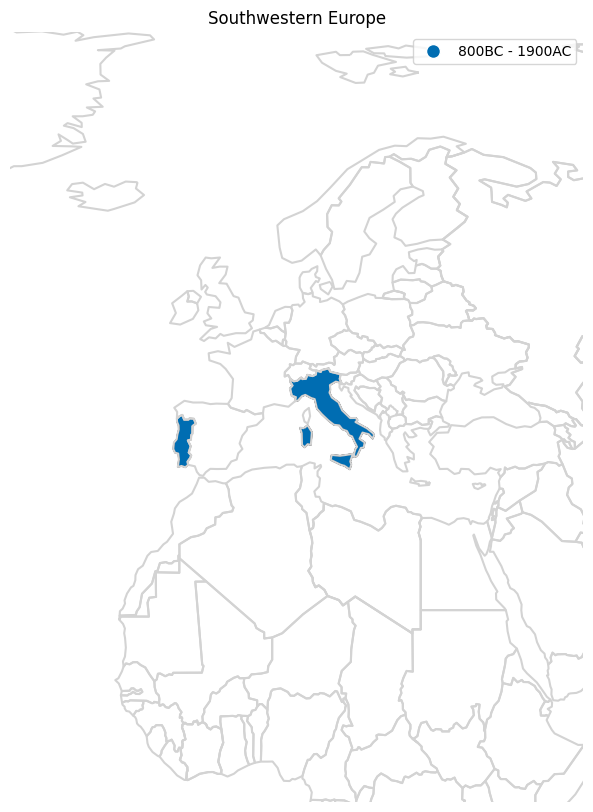

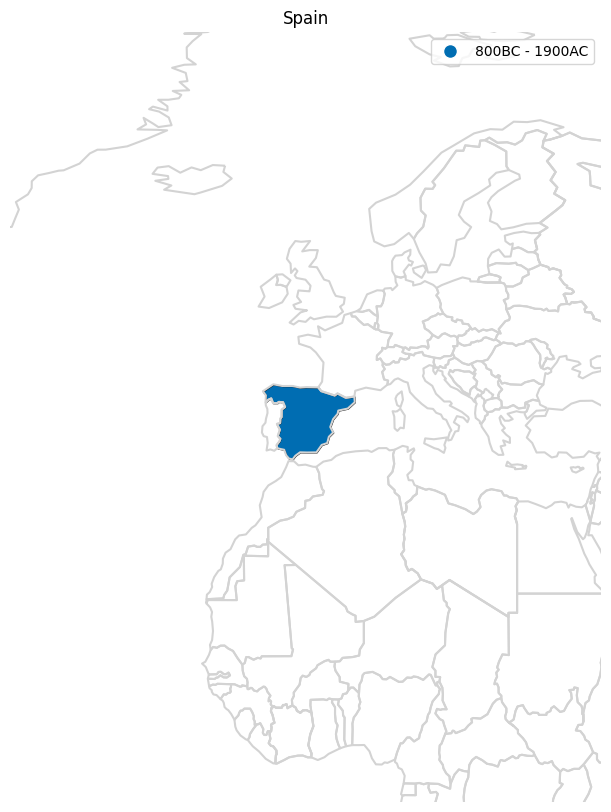

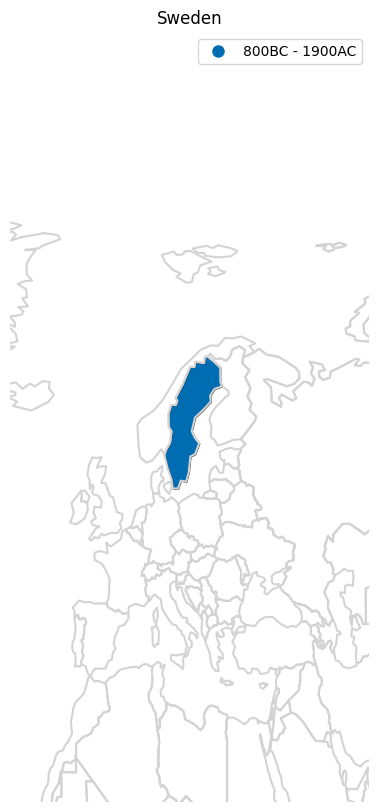

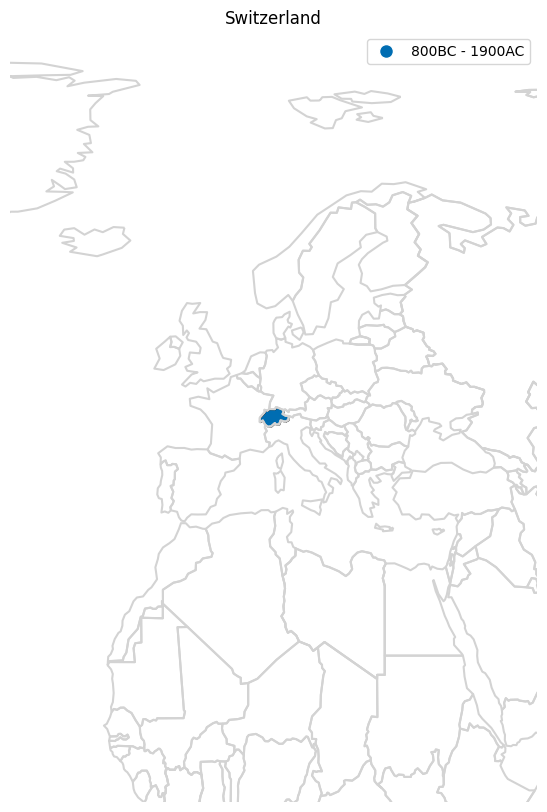

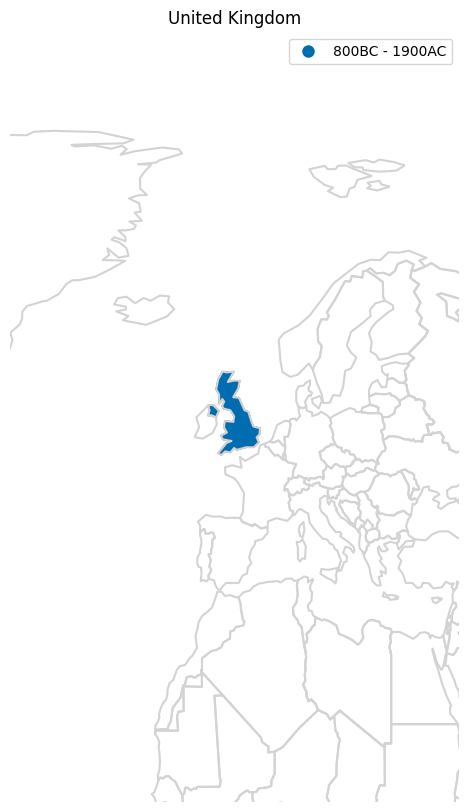

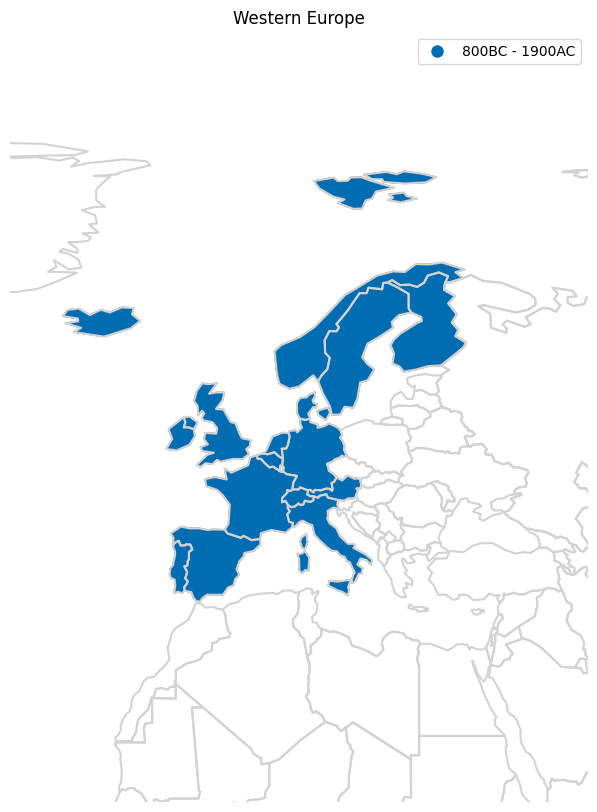

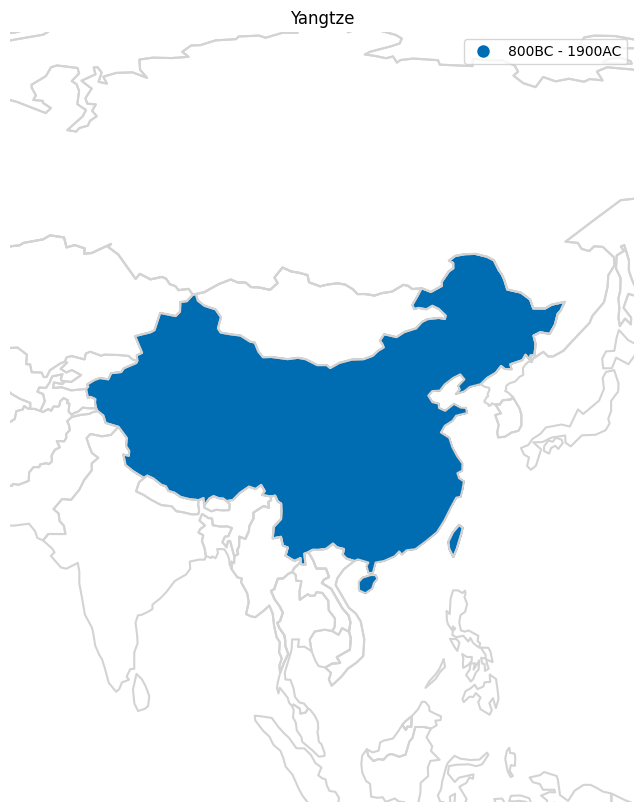

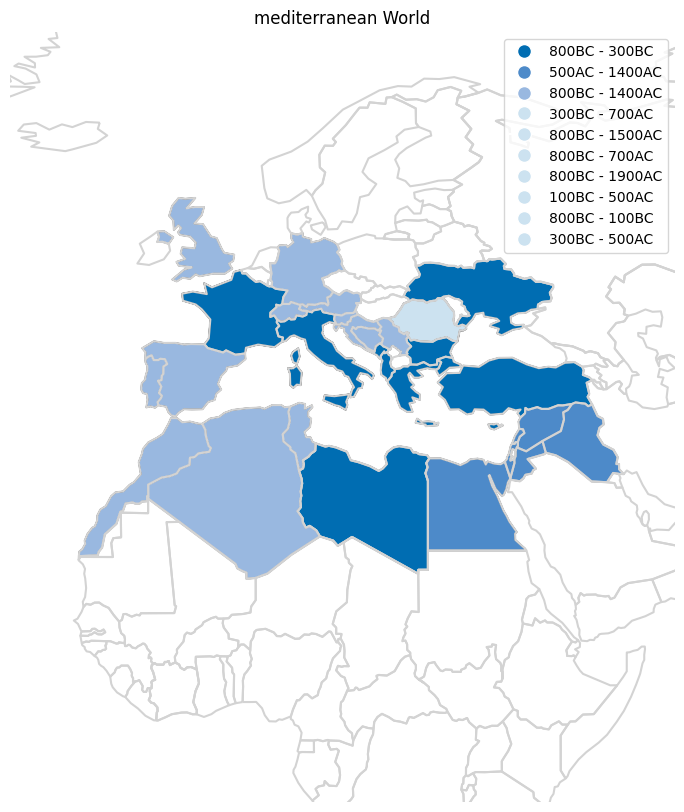

In [150]:

# Create a discrete colormap with shades of blue based on time
cmap = ListedColormap(['#005A8C', '#3477A5', '#6B95BD', '#99B8E0', '#CCE2F0', '#E6F2FA'])

# Iterate through region codes and plot maps
for region_code, region_data in gdf.groupby('region'):
    
    try:

        # Merge with world map to get geometries
        merged_data = pd.merge(world, region_data, on='iso_a2')
        
        # Create a colormap with a different color for each unique min_date
        cmap = ListedColormap(['#006DB2', '#4D8AC9', '#99B8E0', '#CCE2F0'])
        
        # Calculate the centroid of the region's geometries
        region_centroid = merged_data.geometry.unary_union.centroid

        # Plot the map centered around the region's centroid
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_title(region_code)

        # Set the aspect ratio to be equal for a square plot
        ax.set_aspect('equal')

        # Set the map extent based on the region's centroid
        ax.set_xlim([region_centroid.x - 40, region_centroid.x + 40])
        ax.set_ylim([region_centroid.y - 40, region_centroid.y + 40])

        ax.axis('off')  # Hide the axis

        world.boundary.plot(ax=ax, color='lightgrey')  # Plot the world map boundaries in black
        plot = merged_data.plot(ax=ax, cmap=cmap, edgecolor='black', column='min_date', legend=False, cax=False)  # Plot the region data with shades of blue

        gdf_filtered = gdf[gdf['region']==region_code]

        # Add legend without vertical scale and with unique time ranges
        legend_elements = []
        unique_ranges = set(zip(gdf_filtered['min_date'], gdf_filtered['max_date']))

        formatted_ranges = []

        for values in unique_ranges:
            min_val = values[0]
            if min_val < 0:
                new_min_val = str(abs(int(min_val))) + 'BC'
            elif min_val >= 0:
                new_min_val = str(abs(int(min_val))) + 'AC'

            max_val = values[1]
            if max_val < 0:
                new_max_val = str(abs(int(max_val))) + 'BC'
            elif max_val >= 0:
                new_max_val = str(abs(int(max_val))) + 'AC'

            res = new_min_val + ' - ' + new_max_val
            formatted_ranges.append(res)

        formatted_ranges = set(formatted_ranges)

        for i, (min_val, max_val) in enumerate(unique_ranges):
            legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10))
            labels = f'{int(min_val)} - {int(max_val)}'  # Modify this line to format the labels without "()"

        plot.legend(legend_elements, formatted_ranges, title='', loc='upper right')

        # Save or display the plot
        plt.savefig(f'map_figures/map_{region_code}.png', bbox_inches='tight', pad_inches=0.1)
        plt.show()  # Display the map
        
    except:
        pass


# Close all plots
plt.close('all')
